In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import pickle

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay, root_mean_squared_error, r2_score, f1_score
import time

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Initial Preprocessing

In [2]:
df = pd.read_csv("../Resources/combined_cleaned.csv")
df.head()

,id,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129487 non-null  int64  
 1   gender                             129487 non-null  object 
 2   customer_type                      129487 non-null  object 
 3   age                                129487 non-null  int64  
 4   type_of_travel                     129487 non-null  object 
 5   travel_class                       129487 non-null  object 
 6   flight_distance                    129487 non-null  int64  
 7   inflight_wifi_service              129487 non-null  int64  
 8   departure_arrival_time_convenient  129487 non-null  int64  
 9   ease_of_online_booking             129487 non-null  int64  
 10  gate_location                      129487 non-null  int64  
 11  food_and_drink                     1294

In [4]:
# FEATURE ENGINEERING

df["arrival_delay_in_minutes"] = df["arrival_delay_in_minutes"].astype('int')
df.drop(columns=["id"], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129487 non-null  object
 1   customer_type                      129487 non-null  object
 2   age                                129487 non-null  int64 
 3   type_of_travel                     129487 non-null  object
 4   travel_class                       129487 non-null  object
 5   flight_distance                    129487 non-null  int64 
 6   inflight_wifi_service              129487 non-null  int64 
 7   departure_arrival_time_convenient  129487 non-null  int64 
 8   ease_of_online_booking             129487 non-null  int64 
 9   gate_location                      129487 non-null  int64 
 10  food_and_drink                     129487 non-null  int64 
 11  online_boarding                    129487 non-null  

In [6]:
# Binning for columns with too many categories

# Define the custom transformer for multiple columns
class BinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bins_dict, labels_dict):
        self.bins_dict = bins_dict
        self.labels_dict = labels_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_binned = X.copy()
        for column in self.bins_dict.keys():
            X_binned[column] = pd.cut(X_binned[column], bins=self.bins_dict[column], labels=self.labels_dict[column], include_lowest=True)
        return X_binned

    def get_feature_names_out(self, input_features=None):
        # Generate feature names based on the labels_dict
        if input_features is None:
            return self.labels_dict.values()
        else:
            return [f"{feature}_{label}" for feature in input_features for label in self.labels_dict[feature]]

# Define bins and labels for each column
bins_dict = {
    'flight_distance': [0, 99, 199, 299, 399, 499, 599, 799, 999, 1499, 1999, 2999, 4999],
    'departure_delay_in_minutes': [0, 30, 60, 120, 180, 240, 300, 360, 420, 480, 2000],
    'arrival_delay_in_minutes': [0, 30, 60, 120, 180, 240, 300, 360, 420, 480, 2000]
}

labels_dict = {
    'flight_distance': ["0-99", "100-199", "200-299", "300-399", "400-499", "500-599", "600-799", "800-999", "1000-1499", "1500-1999", "2000-2999", "3000-4999"],
    'departure_delay_in_minutes':["0-29", "30-59", "60-119", "120-179", "180-239", "240-299", "300-359", "360-419", "420-479", "480-1999"],
    'arrival_delay_in_minutes': ["0-29", "30-59", "60-119", "120-179", "180-239", "240-299", "300-359", "360-419", "420-479", "480-1999"]
}

In [7]:
binning_transformer = BinningTransformer(bins_dict, labels_dict)
binned_df = binning_transformer.fit_transform(df)
print(binned_df.info())
binned_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   gender                             129487 non-null  object  
 1   customer_type                      129487 non-null  object  
 2   age                                129487 non-null  int64   
 3   type_of_travel                     129487 non-null  object  
 4   travel_class                       129487 non-null  object  
 5   flight_distance                    129487 non-null  category
 6   inflight_wifi_service              129487 non-null  int64   
 7   departure_arrival_time_convenient  129487 non-null  int64   
 8   ease_of_online_booking             129487 non-null  int64   
 9   gate_location                      129487 non-null  int64   
 10  food_and_drink                     129487 non-null  int64   
 11  online_boarding           

,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,100-199,5,4,3,4,3,4,3,5,5,5,5,2,5,5,30-59,30-59,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2000-2999,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0-29,0-29,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,100-199,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0-29,0-29,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3000-4999,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0-29,0-29,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1000-1499,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0-29,0-29,satisfied


In [8]:
# Change columns to strings for OneHot Encoding
binned_df["arrival_delay_in_minutes"] = binned_df["arrival_delay_in_minutes"].astype('str')
binned_df["departure_delay_in_minutes"] = binned_df["departure_delay_in_minutes"].astype('str')
binned_df["flight_distance"] = binned_df["flight_distance"].astype('str')

In [9]:
# Check binary columns for imbalance
binary_cols = ["satisfaction", "gender", "customer_type", "type_of_travel"]

for col in binary_cols:
  print(binned_df[col].value_counts())
  print()

satisfaction
neutral or dissatisfied    73225
satisfied                  56262
Name: count, dtype: int64

gender
Female    65703
Male      63784
Name: count, dtype: int64

customer_type
Loyal Customer       105773
disloyal Customer     23714
Name: count, dtype: int64

type_of_travel
Business travel    89445
Personal Travel    40042
Name: count, dtype: int64



In [10]:
# Convert binary columns into numeric values
binned_df["satisfaction"] = binned_df.satisfaction.apply(lambda x: 1 if x=="satisfied" else 0)
# binned_df["gender"] = binned_df.gender.apply(lambda x: 1 if x=="Female" else 0)
# binned_df["customer_type"] = binned_df.customer_type.apply(lambda x: 1 if x=="Loyal Customer" else 0)
# binned_df["type_of_travel"] = binned_df.type_of_travel.apply(lambda x: 1 if x=="Business travel" else 0)

In [11]:
# # Confirm numeric conversion
# binary_cols = ["satisfaction", "gender", "customer_type", "type_of_travel"]
# for col in binary_cols:
#   print(binned_df[col].value_counts())
#   print()

In [12]:
binned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129487 non-null  object
 1   customer_type                      129487 non-null  object
 2   age                                129487 non-null  int64 
 3   type_of_travel                     129487 non-null  object
 4   travel_class                       129487 non-null  object
 5   flight_distance                    129487 non-null  object
 6   inflight_wifi_service              129487 non-null  int64 
 7   departure_arrival_time_convenient  129487 non-null  int64 
 8   ease_of_online_booking             129487 non-null  int64 
 9   gate_location                      129487 non-null  int64 
 10  food_and_drink                     129487 non-null  int64 
 11  online_boarding                    129487 non-null  

## Preprocessing Pipeline

In [13]:
# Confirm data types are appropriate for preprocessing pipeline
binned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129487 non-null  object
 1   customer_type                      129487 non-null  object
 2   age                                129487 non-null  int64 
 3   type_of_travel                     129487 non-null  object
 4   travel_class                       129487 non-null  object
 5   flight_distance                    129487 non-null  object
 6   inflight_wifi_service              129487 non-null  int64 
 7   departure_arrival_time_convenient  129487 non-null  int64 
 8   ease_of_online_booking             129487 non-null  int64 
 9   gate_location                      129487 non-null  int64 
 10  food_and_drink                     129487 non-null  int64 
 11  online_boarding                    129487 non-null  

In [14]:
df_prep = binned_df.copy()
df_prep.drop(columns=["satisfaction"], inplace=True)
df_prep.shape

(129487, 22)

In [15]:
# Preprocessing pipeline

binary_features = ['gender', 'customer_type', 'type_of_travel']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('ordinal_encoder', OrdinalEncoder())
])

numeric_features = ['age', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['travel_class', 'flight_distance', 'departure_delay_in_minutes', 
        'arrival_delay_in_minutes']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    # Set sparse_output=False to return a dense array
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [16]:
# Create and test pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform DataFrame 
df_transformed = pipeline.fit_transform(df_prep)
print(df_transformed.shape)
print(type(df_transformed))

# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features + 
    list(preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_features)))
print(len(encoded_feature_names))
print("\n".join(encoded_feature_names))

df_pipe = pd.DataFrame(df_transformed, columns=encoded_feature_names)
print(df_pipe.shape)
df_pipe.head()

(129487, 53)
<class 'numpy.ndarray'>
53
age
inflight_wifi_service
departure_arrival_time_convenient
ease_of_online_booking
gate_location
food_and_drink
online_boarding
seat_comfort
inflight_entertainment
on_board_service
leg_room_service
baggage_handling
checkin_service
inflight_service
cleanliness
gender
customer_type
type_of_travel
travel_class_Business
travel_class_Eco
travel_class_Eco Plus
flight_distance_0-99
flight_distance_100-199
flight_distance_1000-1499
flight_distance_1500-1999
flight_distance_200-299
flight_distance_2000-2999
flight_distance_300-399
flight_distance_3000-4999
flight_distance_400-499
flight_distance_500-599
flight_distance_600-799
flight_distance_800-999
departure_delay_in_minutes_0-29
departure_delay_in_minutes_120-179
departure_delay_in_minutes_180-239
departure_delay_in_minutes_240-299
departure_delay_in_minutes_30-59
departure_delay_in_minutes_300-359
departure_delay_in_minutes_360-419
departure_delay_in_minutes_420-479
departure_delay_in_minutes_480-1999

,age,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,gender,customer_type,type_of_travel,travel_class_Business,travel_class_Eco,travel_class_Eco Plus,flight_distance_0-99,flight_distance_100-199,flight_distance_1000-1499,flight_distance_1500-1999,flight_distance_200-299,flight_distance_2000-2999,flight_distance_300-399,flight_distance_3000-4999,flight_distance_400-499,flight_distance_500-599,flight_distance_600-799,flight_distance_800-999,departure_delay_in_minutes_0-29,departure_delay_in_minutes_120-179,departure_delay_in_minutes_180-239,departure_delay_in_minutes_240-299,departure_delay_in_minutes_30-59,departure_delay_in_minutes_300-359,departure_delay_in_minutes_360-419,departure_delay_in_minutes_420-479,departure_delay_in_minutes_480-1999,departure_delay_in_minutes_60-119,arrival_delay_in_minutes_0-29,arrival_delay_in_minutes_120-179,arrival_delay_in_minutes_180-239,arrival_delay_in_minutes_240-299,arrival_delay_in_minutes_30-59,arrival_delay_in_minutes_300-359,arrival_delay_in_minutes_360-419,arrival_delay_in_minutes_420-479,arrival_delay_in_minutes_480-1999,arrival_delay_in_minutes_60-119
0,0.831567,1.708851,0.617410,0.173519,0.800227,-0.153910,0.553276,-0.334749,1.230701,1.256225,1.252860,1.159342,-1.031669,1.153847,1.304624,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.226807,-1.300410,-1.347508,0.173519,-1.546271,1.349963,0.553276,1.181364,0.481157,0.479240,0.493055,0.311941,-0.241868,0.303947,1.304624,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.285180,-0.548095,-2.002480,-0.539923,0.800227,-0.905846,-0.927497,-1.092806,-1.017931,0.479240,-1.786361,-0.535461,-1.031669,-1.395853,-0.979144,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.302380,-2.052726,-2.002480,-1.966806,-0.764105,-0.153910,0.553276,0.423307,-1.767475,-1.851712,-1.786361,-2.230265,-0.241868,-2.245753,0.543368,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.633122,-0.548095,-0.037562,0.886960,0.018061,0.598027,-1.667884,-1.092806,-1.017931,-1.074728,-1.026556,-1.382863,0.547933,-1.395853,0.543368,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 53 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   age                                  129487 non-null  float64
 1   inflight_wifi_service                129487 non-null  float64
 2   departure_arrival_time_convenient    129487 non-null  float64
 3   ease_of_online_booking               129487 non-null  float64
 4   gate_location                        129487 non-null  float64
 5   food_and_drink                       129487 non-null  float64
 6   online_boarding                      129487 non-null  float64
 7   seat_comfort                         129487 non-null  float64
 8   inflight_entertainment               129487 non-null  float64
 9   on_board_service                     129487 non-null  float64
 10  leg_room_service                     129487 non-null  float64
 11  baggage_handl

In [18]:
df_pipe.columns

Index(['age', 'inflight_wifi_service', 'departure_arrival_time_convenient',
       'ease_of_online_booking', 'gate_location', 'food_and_drink',
       'online_boarding', 'seat_comfort', 'inflight_entertainment',
       'on_board_service', 'leg_room_service', 'baggage_handling',
       'checkin_service', 'inflight_service', 'cleanliness', 'gender',
       'customer_type', 'type_of_travel', 'travel_class_Business',
       'travel_class_Eco', 'travel_class_Eco Plus', 'flight_distance_0-99',
       'flight_distance_100-199', 'flight_distance_1000-1499',
       'flight_distance_1500-1999', 'flight_distance_200-299',
       'flight_distance_2000-2999', 'flight_distance_300-399',
       'flight_distance_3000-4999', 'flight_distance_400-499',
       'flight_distance_500-599', 'flight_distance_600-799',
       'flight_distance_800-999', 'departure_delay_in_minutes_0-29',
       'departure_delay_in_minutes_120-179',
       'departure_delay_in_minutes_180-239',
       'departure_delay_in_minutes_

<Axes: >

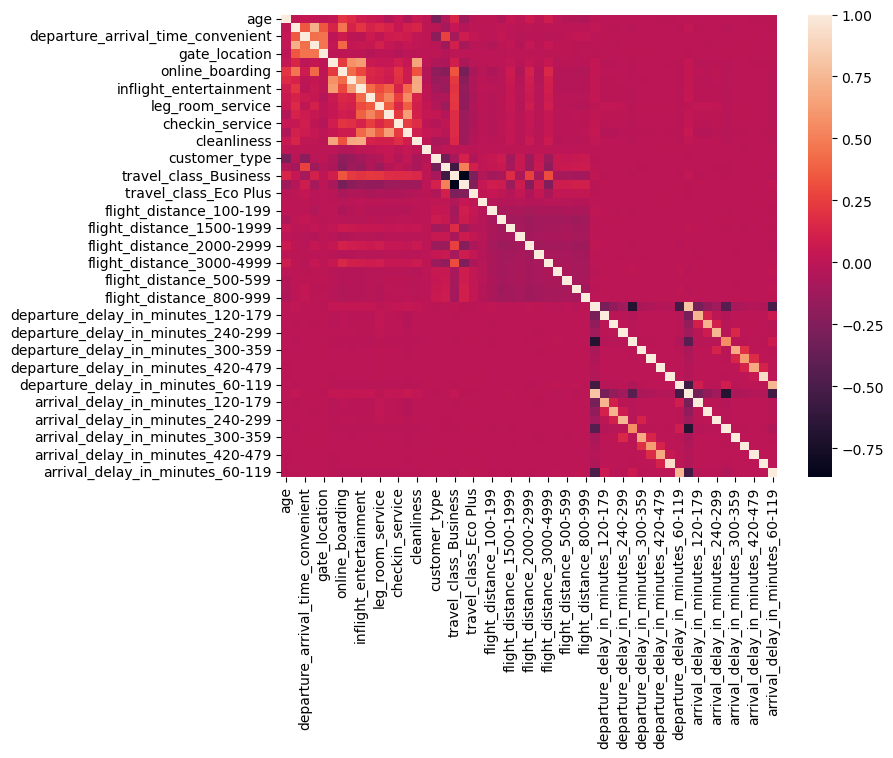

In [19]:
# View possible feature correlations
corrs = df_pipe.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corrs)

In [20]:
# Split preprocessed data into features and target arrays
X = binned_df.drop(columns=["satisfaction"])
y = binned_df.satisfaction
X.shape

(129487, 22)

In [21]:
y.value_counts()

satisfaction
0    73225
1    56262
Name: count, dtype: int64

In [22]:
# Split the preprocessed data into a training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(97115, 22) (32372, 22)
(97115,) (32372,)


In [23]:
print(X_train.columns)
X_train.head()
# Unscaled, unencoded

Index(['gender', 'customer_type', 'age', 'type_of_travel', 'travel_class',
       'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes',
       'arrival_delay_in_minutes'],
      dtype='object')


,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
51117,Male,Loyal Customer,32,Personal Travel,Eco,1500-1999,3,5,4,3,4,4,4,4,3,4,4,4,4,4,0-29,0-29
102367,Male,Loyal Customer,44,Business travel,Eco,1500-1999,1,4,3,4,2,1,2,2,1,3,3,3,4,2,0-29,0-29
78188,Male,Loyal Customer,33,Business travel,Business,3000-4999,2,5,5,5,2,2,2,2,4,1,3,3,3,2,0-29,0-29
7032,Female,Loyal Customer,25,Business travel,Business,500-599,1,5,5,5,1,2,1,1,3,4,4,2,4,1,0-29,0-29
73647,Male,Loyal Customer,20,Personal Travel,Business,800-999,4,4,4,4,4,4,4,1,4,4,3,4,1,4,360-419,300-359


## Model Experimentation

In [24]:
# FUNCTION FOR CLASSIFICATION MODELING

def classificationModeling(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)

    train_results = f"""TRAIN METRICS
    Train Confusion Matrix:
    {train_cf}

    Train Classification Report:
    {train_cr}

    Train AUC: {train_auc}
    """

    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)

    test_results = f"""TEST METRICS
    Test Confusion Matrix:
    {test_cf}

    Test Classification Report:
    {test_cr}

    Test AUC: {test_auc}
    """

    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')

    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

### Light Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54376   543]
 [ 1606 40590]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.97      0.99      0.98     54919
           1       0.99      0.96      0.97     42196

    accuracy                           0.98     97115
   macro avg       0.98      0.98      0.98     97115
weighted avg       0.98      0.98      0.98     97115


    Train AUC: 0.9985885995261049
    
TEST METRICS
    Test Confusion Matrix:
    [[17933   373]
 [  825 13241]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     18306
           1       0.97      0.94      0.96     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9950393117933563
    


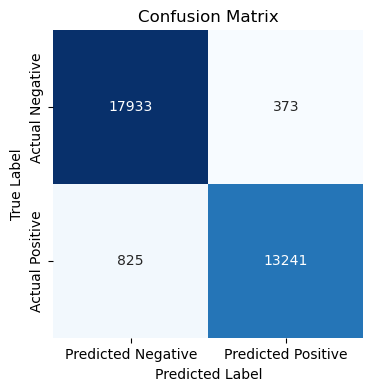

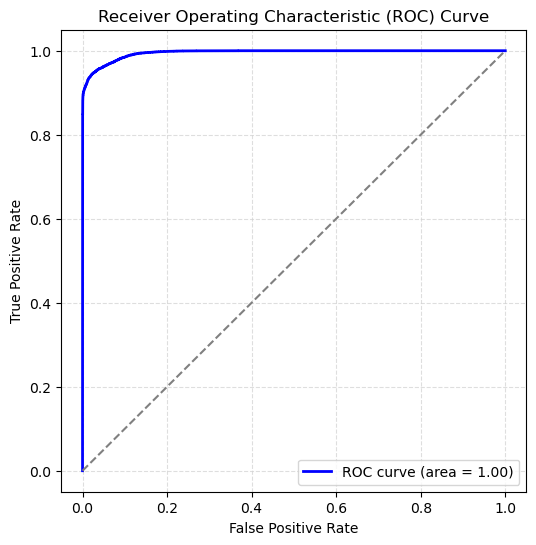

In [25]:
# Initiate the model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state = 42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])

# Machine Learning
classificationModeling(lgbm, X_train, X_test, y_train, y_test)

## Analytics

In [26]:
# LGBM Feature Importances
fi_lgbm = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['model'].feature_importances_ / sum(lgbm.named_steps['model'].feature_importances_))), columns=["Feature", "Importance"])
fi_lgbm.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,gender,0.132952
1,customer_type,0.079810
11,online_boarding,0.056095
13,inflight_entertainment,0.053810
4,travel_class,0.052190
12,seat_comfort,0.048952
6,inflight_wifi_service,0.044476
10,food_and_drink,0.044095
7,departure_arrival_time_convenient,0.043048
9,gate_location,0.042762


In [27]:
# Cross Validation to evaluate the model on the ENTIRE dataset
# Is there bias in our train_test_split?

In [28]:
# Cross Validation on LGBM model: AUC
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"LGBM Cross-validation AUC scores: {cv_scores}")
print(f"LGBM Mean AUC: {np.mean(cv_scores):.4f}")

LGBM Cross-validation AUC scores: [0.99533129 0.99491067 0.99545013 0.99547466 0.9955728 ]
LGBM Mean AUC: 0.9953


In [29]:
# Cross Validation on LGBM model: accuracy
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='accuracy')

# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.96493938 0.96389683 0.96435881 0.96470634 0.96713905]
LGBM Mean accuracy: 0.9650


In [30]:
# Cross Validation on LGBM model: precision
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])

# Perform 5-fold cross-validation with precision scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='precision')

# Output the results
print(f"LGBM Cross-validation precision scores: {cv_scores}")
print(f"LGBM Mean precision: {np.mean(cv_scores):.4f}")

LGBM Cross-validation precision scores: [0.97406287 0.97487113 0.97229081 0.97605452 0.97873516]
LGBM Mean precision: 0.9752


In [31]:
# Cross Validation on LGBM model: recall
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])

# Perform 5-fold cross-validation with recall scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='recall')

# Output the results
print(f"LGBM Cross-validation recall scores: {cv_scores}")
print(f"LGBM Mean recall: {np.mean(cv_scores):.4f}")

LGBM Cross-validation recall scores: [0.94445926 0.94117124 0.94489868 0.941877   0.94489868]
LGBM Mean recall: 0.9435


In [32]:
# Cross Validation on LGBM model: f1
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])

# Perform 5-fold cross-validation with f1 scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='f1')

# Output the results
print(f"LGBM Cross-validation f1 scores: {cv_scores}")
print(f"LGBM Mean f1: {np.mean(cv_scores):.4f}")

LGBM Cross-validation f1 scores: [0.95903267 0.95772483 0.95839906 0.95866124 0.96151933]
LGBM Mean f1: 0.9591


## Model Productionalization

In [33]:
# Retrain the model on the ENTIRE dataset
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, learning_rate = 0.1, n_estimators = 350, verbose=-1))
])
lgbm.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'inflight_wifi_service',
                                                   'departure_arrival_time_convenient',
                                                   'ease_of_online_booking',
                                                   'gate_location',
                                                   'food_and_drink',
                                                   'online_boarding',
                                                   'seat_comfort',
                                                   'inflight_entertainment',
                                                   '...
                                                   'type_of_travel']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=<NA>,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['travel_class',
                                                   'flight_distance',
                                                   'departure_delay_in_minutes',
                                                   'arrival_delay_in_minutes'])])),
                ('model',
                 LGBMClassifier(n_estimators=350, random_state=42,
                                verbose=-1))])

In [34]:
# Save model
model = pickle.dump(lgbm, open("model_pipeline.h5", 'wb'))
# wb = write binary for the h5 file